# Quantium Virtual Internship - Retail Strategy and Analytics - Task 2
Author: Tien Vinh Dang

In [74]:
import pandas as pd
import matplotlib.pyplot as plt     
from datetime import datetime       
import numpy as np                  
import seaborn as sns
import duckdb

In [75]:
data = pd.read_csv('QVI_data.csv')
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established stores that are operational for the entire observation period.

We would want to match trial stores to control stores that are similar to the trial store prior to the trial period of Feb 2019 in terms of :
- Monthly overall sales revenue

- Monthly number of customers

- Monthly number of transactions per customer

Let's first create the metrics of interest and filter to stores that are present throughout the pre-trial period

#### Calculate these measures over time for each store 
Let's add a new month ID column in the data with the format yyyymm.

In [76]:
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].dt.strftime('%Y%m')
data.sort_values('DATE')
data

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810


#### Next, we define the measure calculations to use during the analysis.
For each store and month calculate total sales, number of customers, transactions per customer, chips per customer and the average price per unit.

In [77]:
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    n_customers=('LYLTY_CARD_NBR', 'nunique'),
    n_transactions=('TXN_ID', 'nunique'),
    total_units=('PROD_QTY', 'sum')
).reset_index()
measure_over_time['txn_per_customer'] = measure_over_time['n_transactions'] / measure_over_time['n_customers']
measure_over_time['chips_per_customer'] = measure_over_time['total_units'] / measure_over_time['n_customers']
measure_over_time['avg_price_per_unit'] = measure_over_time['total_sales'] / measure_over_time['total_units']
measure_over_time

,STORE_NBR,YEARMONTH,total_sales,n_customers,n_transactions,total_units,txn_per_customer,chips_per_customer,avg_price_per_unit
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,1.066667,2.022222,4.346154
3165,272,201903,442.3,50,53,101,1.060000,2.020000,4.379208
3166,272,201904,445.1,54,55,105,1.018519,1.944444,4.239048
3167,272,201905,314.6,34,40,71,1.176471,2.088235,4.430986


### Filter to the pre-trial period and stores with full observation periods 

In [78]:
pre_trial_months = ['201807', '201808', '201809', '201810', '201811', '201812', '201901']
pre_trial_measure = measure_over_time[measure_over_time['YEARMONTH'].isin(pre_trial_months)]
store_month_counts = pre_trial_measure.groupby('STORE_NBR')['YEARMONTH'].nunique()
full_period_stores = store_month_counts[store_month_counts == 7].index
pre_trial_measure_full = pre_trial_measure[pre_trial_measure['STORE_NBR'].isin(full_period_stores)]
pre_trial_measure_full

,STORE_NBR,YEARMONTH,total_sales,n_customers,n_transactions,total_units,txn_per_customer,chips_per_customer,avg_price_per_unit
0,1,201807,206.9,49,52,62,1.061224,1.265306,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.285714,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.271186,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.318182,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.239130,3.378947
...,...,...,...,...,...,...,...,...,...
3159,272,201809,304.7,32,36,71,1.125000,2.218750,4.291549
3160,272,201810,430.6,44,50,99,1.136364,2.250000,4.349495
3161,272,201811,376.2,41,45,87,1.097561,2.121951,4.324138
3162,272,201812,403.9,47,47,89,1.000000,1.893617,4.538202


Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each store is to the trial store.

Let's write a function for this so that we don't have to calculate this for each trial store and control store pair.

In [79]:
def calculate_correlation(input_table, metric_col, store_nbr):
    pivot = input_table.pivot(index='YEARMONTH', columns='STORE_NBR', values=metric_col)
    trial_series = pivot[store_nbr]
    result = []

    for store in pivot.columns:
        if store == store_nbr:
            continue  # skip trial store itself

        corr = trial_series.corr(pivot[store])
        result.append({'Store1': store_nbr, 'Store2': store, 'corr_measure': corr})

    return pd.DataFrame(result).sort_values(by='corr_measure', ascending=False)
corr_table = calculate_correlation(pre_trial_measure_full, 'total_sales', 77)
print(corr_table.head())

     Store1  Store2  corr_measure
67       77      71      0.914106
220      77     233      0.903774
110      77     119      0.867664
15       77      17      0.842668
2        77       3      0.806644


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance.

Let's write a function for this.

In [80]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    trial_data = input_table[input_table['STORE_NBR'] == store_comparison][['YEARMONTH', metric_col]]
    trial_data = trial_data.rename(columns={metric_col: 'trial_metric'})

    # Prepare result list
    dist_rows = []

    # Loop over each control store
    for store in input_table['STORE_NBR'].unique():
        if store == store_comparison:
            continue  # skip comparing store to itself

        control_data = input_table[input_table['STORE_NBR'] == store][['YEARMONTH', metric_col]]
        control_data = control_data.rename(columns={metric_col: 'control_metric'})

        # Merge by YEARMONTH to align both stores' data
        merged = pd.merge(trial_data, control_data, on='YEARMONTH', how='inner')

        # Compute absolute difference for each month
        merged['measure'] = np.abs(merged['trial_metric'] - merged['control_metric'])

        # Add store info
        merged['Store1'] = store_comparison
        merged['Store2'] = store

        dist_rows.append(merged[['Store1', 'Store2', 'YEARMONTH', 'measure']])

    # Combine all rows
    return pd.concat(dist_rows, ignore_index=True)
dist_table = calculate_magnitude_distance(pre_trial_measure_full, 'total_sales', 77)
dist_table.tail()

,Store1,Store2,YEARMONTH,measure
1808,77,272,201809,79.5
1809,77,272,201810,226.1
1810,77,272,201811,130.9
1811,77,272,201812,136.6
1812,77,272,201901,218.6


#### Standardise the magnitude distance so that the measure ranges from 0 to 1

In [81]:
def standardize_magnitude_distance(calc_dist_table):
    min_max = calc_dist_table.groupby(['Store1', 'YEARMONTH'])['measure'] \
                             .agg(minDist='min', maxDist='max') \
                             .reset_index()

    # Merge back to get min and max for each row
    dist_table = calc_dist_table.merge(min_max, on=['Store1', 'YEARMONTH'], how='left')

    # Apply formula to standardise between 0 and 1
    dist_table['magnitudeMeasure'] = 1 - (
        (dist_table['measure'] - dist_table['minDist']) /
        (dist_table['maxDist'] - dist_table['minDist'])
    )

    # Average across months for each store pair
    final_dist_table = dist_table.groupby(['Store1', 'Store2'])['magnitudeMeasure'] \
                                 .mean().reset_index()

    # Rename to match R code
    final_dist_table = final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'})

    return final_dist_table
calc_dist_table = calculate_magnitude_distance(pre_trial_measure_full, 'total_sales', 77)
final_dist_table = standardize_magnitude_distance(calc_dist_table)
print(final_dist_table.head())

   Store1  Store2  mag_measure
0      77       1     0.955061
1      77       2     0.939318
2      77       3     0.354963
3      77       4     0.177414
4      77       5     0.554066


Now let's use the functions to find the control stores! We'll select control storesbased on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. 

So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [82]:
trial_store = 77
corr_nSales = calculate_correlation(pre_trial_measure_full, 'total_sales', trial_store)
corr_nCustomers = calculate_correlation(pre_trial_measure_full, 'n_customers', trial_store)
magDist_nSales = calculate_magnitude_distance(pre_trial_measure_full, 'total_sales', trial_store)
mag_nSales = standardize_magnitude_distance(magDist_nSales)
magDist_nCustomers = calculate_magnitude_distance(pre_trial_measure_full, 'n_customers', trial_store)
mag_nCustomers = standardize_magnitude_distance(magDist_nCustomers)


We'll need to combine the all the scores calculated using our function to create a composite score to rank on.

Let's take a simple average of the correlation and magnitude scores for each driver. 

Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [83]:
corr_weight = 0.5
score_nSales = pd.merge(
    corr_nSales.rename(columns={'corr_measure': 'corr_score'}),
    mag_nSales.rename(columns={'mag_measure': 'mag_score'}),
    on=['Store1', 'Store2']
)
score_nSales['scoreNSales'] = (
    corr_weight * score_nSales['corr_score'] + (1 - corr_weight) * score_nSales['mag_score']
)
score_nCustomers = pd.merge(
    corr_nCustomers.rename(columns={'corr_measure': 'corr_score'}),
    mag_nCustomers.rename(columns={'mag_measure': 'mag_score'}),
    on=['Store1', 'Store2']
)
score_nCustomers['scoreNCust'] = (
    corr_weight * score_nCustomers['corr_score'] + (1 - corr_weight) * score_nCustomers['mag_score']
)
score_nSales.head(5)

,Store1,Store2,corr_score,mag_score,scoreNSales
0,77,71,0.914106,0.454628,0.684367
1,77,233,0.903774,0.987091,0.945433
2,77,119,0.867664,0.434956,0.651310
3,77,17,0.842668,0.882314,0.862491
4,77,3,0.806644,0.354963,0.580803


In [84]:
score_nCustomers.head(5)

,Store1,Store2,corr_score,mag_score,scoreNCust
0,77,233,0.990358,0.992773,0.991566
1,77,119,0.983267,0.426621,0.704944
2,77,254,0.916208,0.937131,0.926670
3,77,113,0.901348,0.419721,0.660535
4,77,84,0.858571,0.924182,0.891377


Now we have a score for each of total number of sales and number of customers.

Let's combine the two via a simple average.

In [85]:
score_Control = pd.merge(
    score_nSales[['Store1', 'Store2', 'scoreNSales']],
    score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
    on=['Store1', 'Store2']
)
score_Control['finalControlScore'] = (
    score_Control['scoreNSales'] * 0.5 +
    score_Control['scoreNCust'] * 0.5
)
score_Control = score_Control.sort_values(by='finalControlScore', ascending=False).reset_index(drop=True)
score_Control.head(5)


,Store1,Store2,scoreNSales,scoreNCust,finalControlScore
0,77,233,0.945433,0.991566,0.968499
1,77,41,0.875075,0.909429,0.892252
2,77,17,0.862491,0.854902,0.858696
3,77,254,0.750788,0.926670,0.838729
4,77,115,0.811868,0.842399,0.827133


In [86]:
control_store = int((score_Control.iloc[0])['Store2']) #just make it 

Now that we have found a control store, let's check visually if the drivers are indeed similar in the period before the trial.

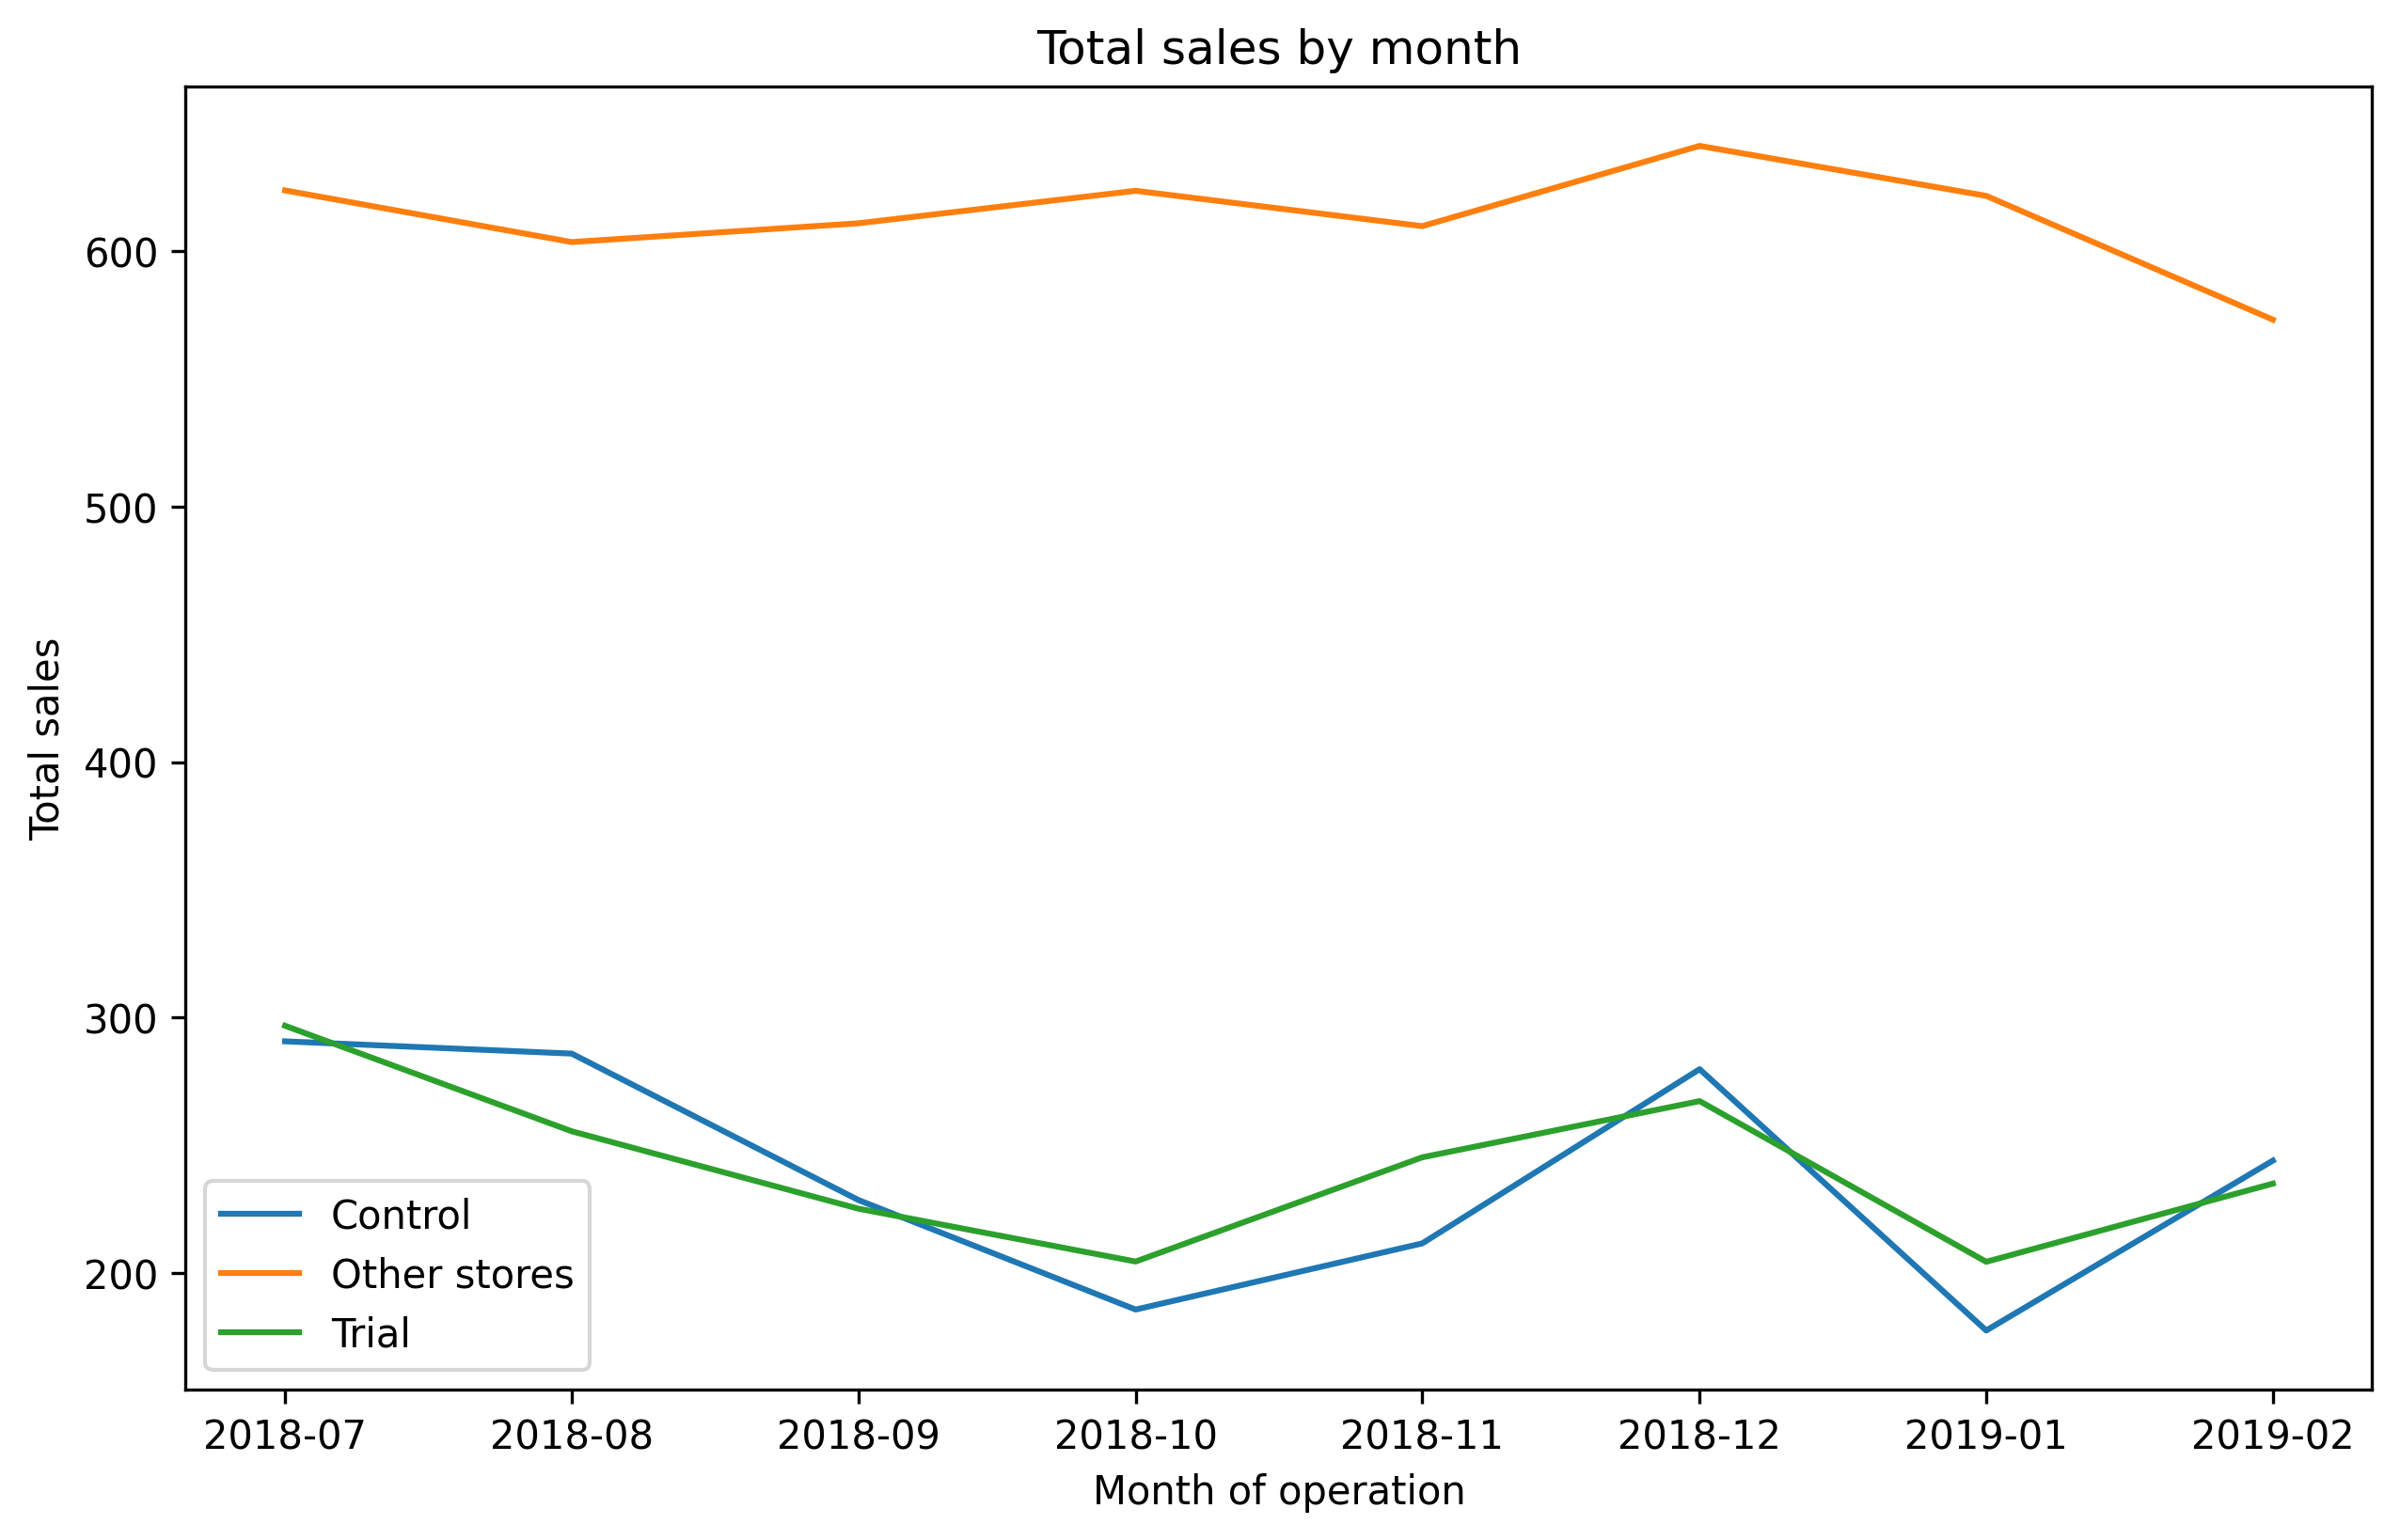

In [87]:
past_sales = measure_over_time.copy()
past_sales['Store_type'] = past_sales['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store
    else 'Control' if x == control_store
    else 'Other stores'
)
past_sales = (past_sales.groupby(['YEARMONTH', 'Store_type'], as_index=False)['total_sales'].mean())
past_sales['TransactionMonth'] = pd.to_datetime(
    past_sales['YEARMONTH'].astype(str).str[:4] + '-' +
    past_sales['YEARMONTH'].astype(str).str[4:] + '-01'
)
past_sales = past_sales[past_sales['YEARMONTH'] < '201903']
plt.figure(figsize=(10, 6), dpi=300)
for store_type, data in past_sales.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['total_sales'], label=store_type)
plt.xlabel("Month of operation")
plt.ylabel("Total sales")
plt.title("Total sales by month")
plt.legend()
plt.show()

Next, number of customers.

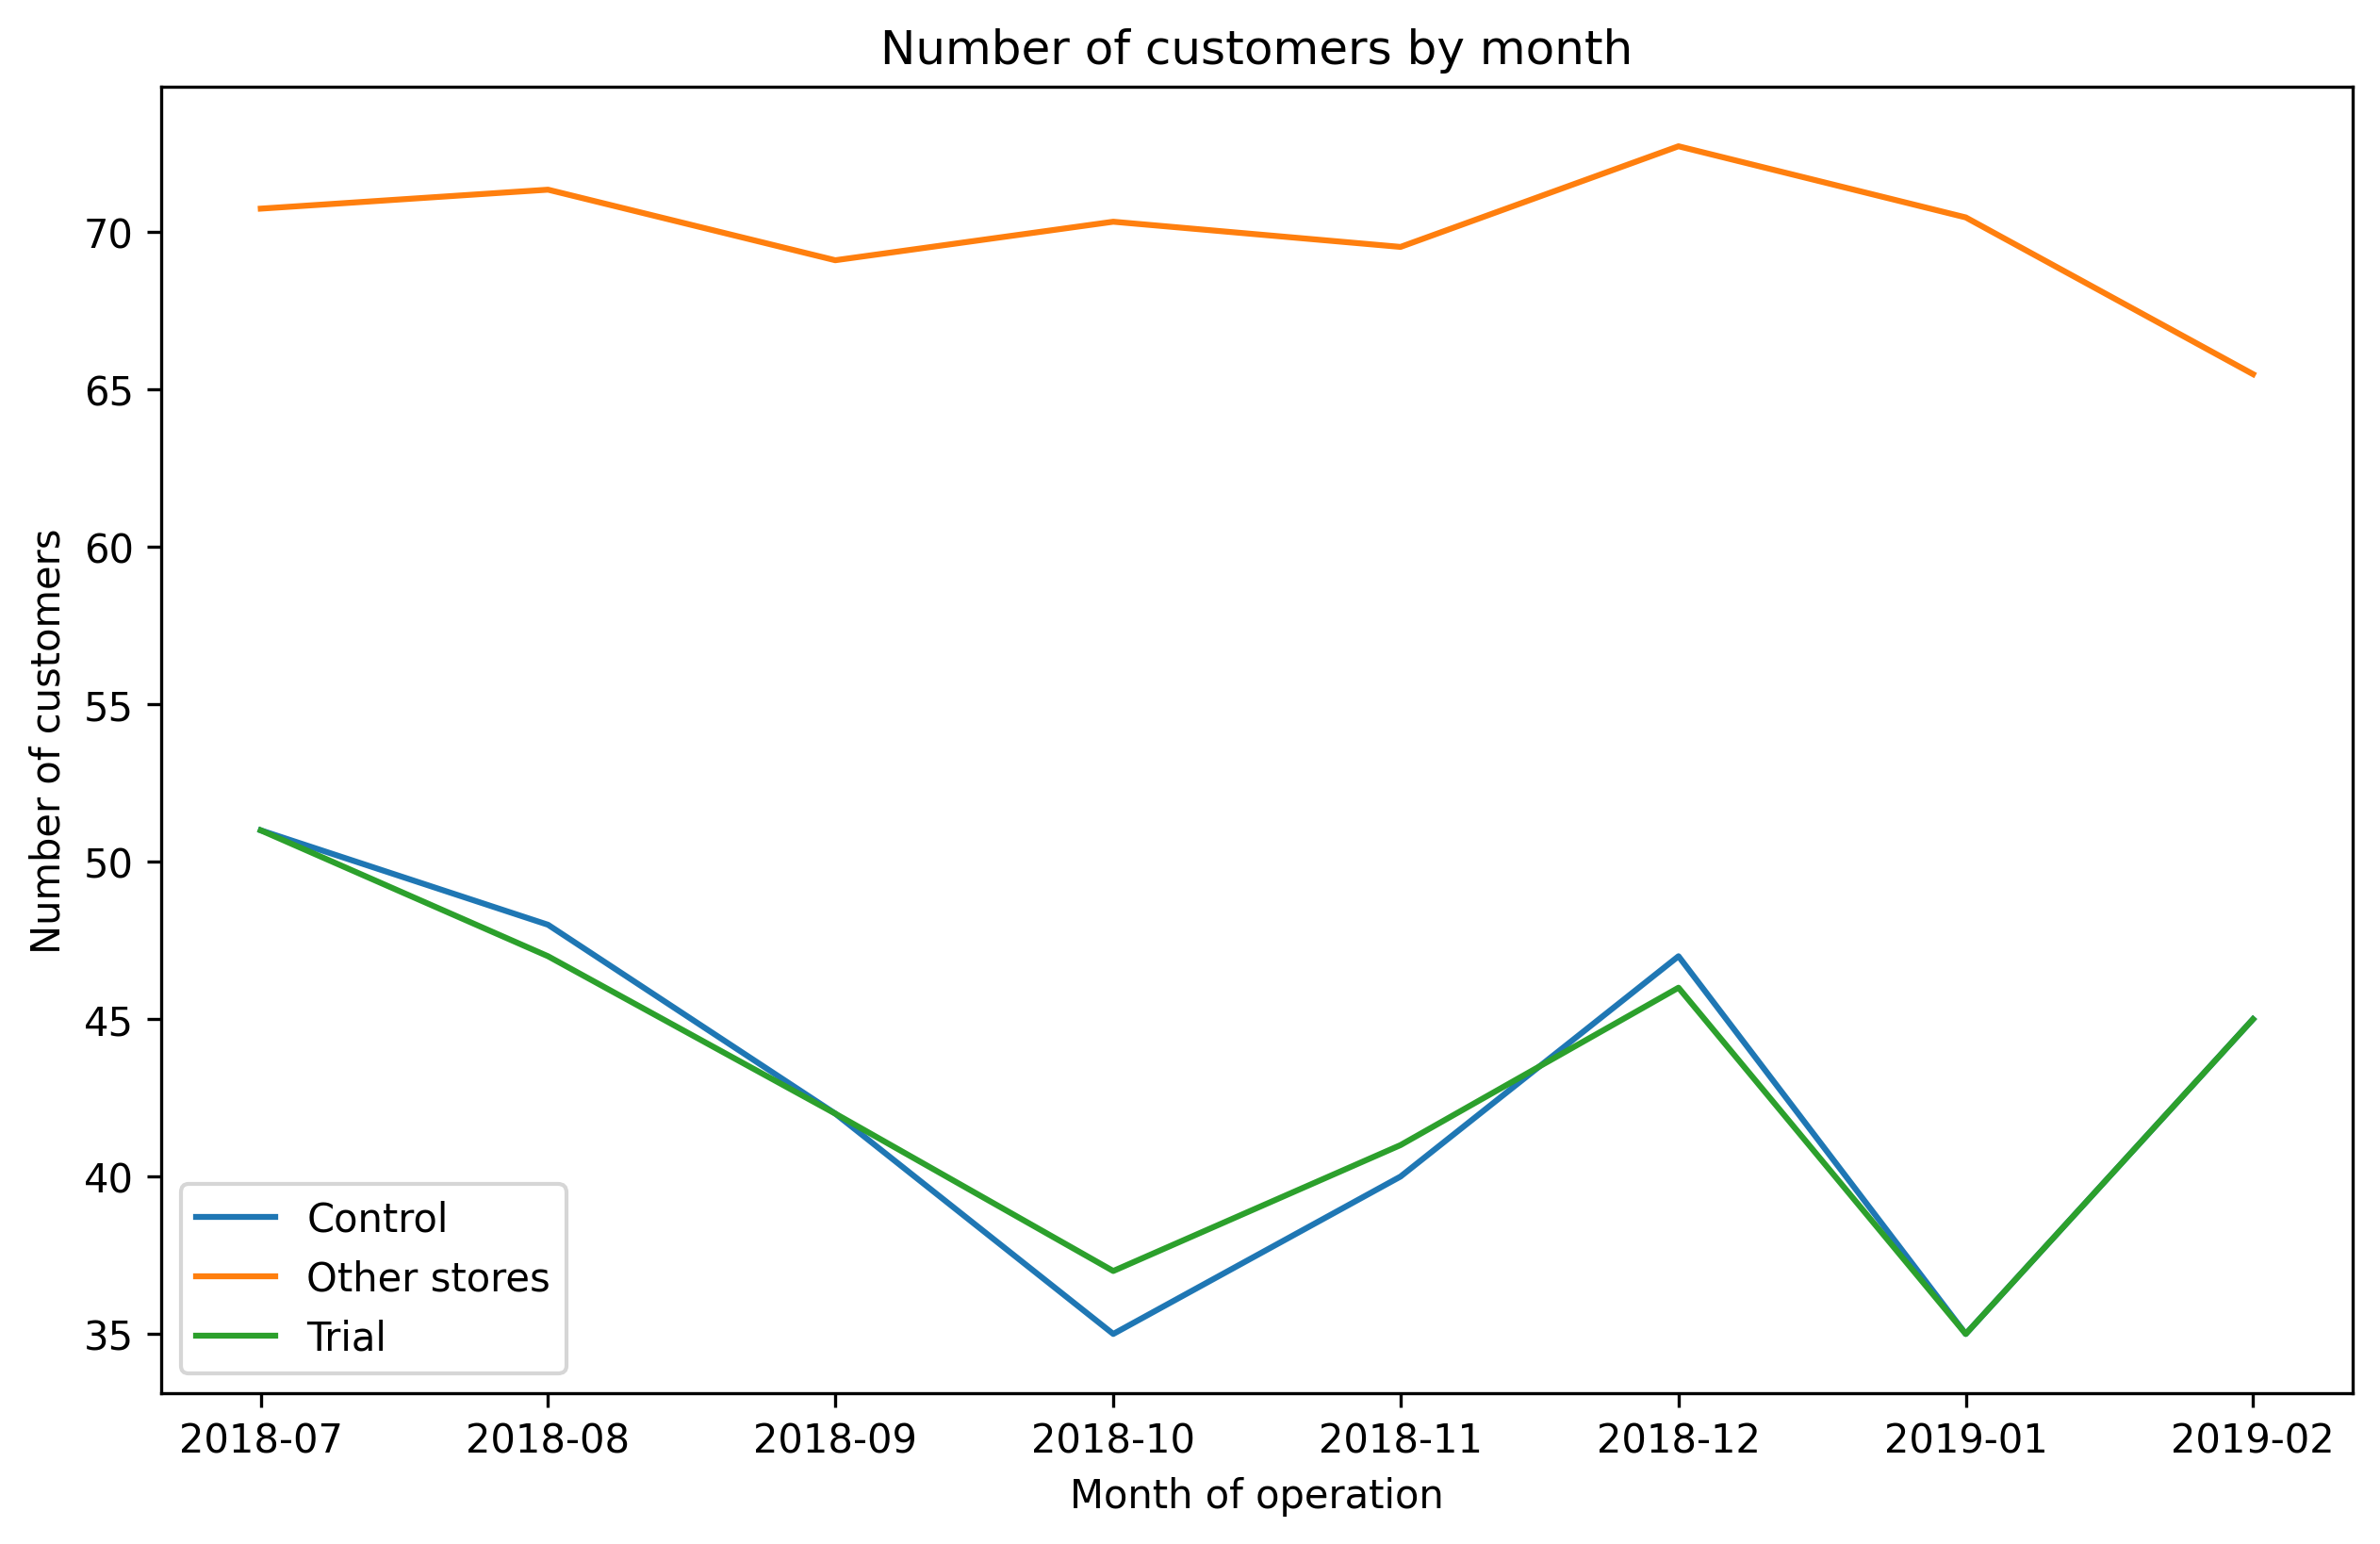

In [88]:
past_customers = measure_over_time.copy()
past_customers['Store_type'] = past_customers['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store
    else 'Control' if x == control_store
    else 'Other stores'
)
past_customers = (
    past_customers.groupby(['YEARMONTH', 'Store_type'], as_index=False)['n_customers']
    .mean()
)
past_customers['TransactionMonth'] = pd.to_datetime(
    past_customers['YEARMONTH'].astype(str).str[:4] + '-' +
    past_customers['YEARMONTH'].astype(str).str[4:] + '-01'
)
past_customers = past_customers[past_customers['YEARMONTH'] < '201903']
plt.figure(figsize=(10, 6), dpi=300)
for store_type, data in past_customers.groupby('Store_type'):
    plt.plot(data['TransactionMonth'], data['n_customers'], label=store_type)
plt.xlabel("Month of operation")
plt.ylabel("Number of customers")
plt.title("Number of customers by month")
plt.legend()
plt.show()


The trial period goes from the start of February 2019 to April 2019. We now want to see if there has been an uplift in overall chip sales.

We'll start with scaling the control store's sales to a level similar to control for any differences between the two stores outside of the trial period. 

#### Scale pre-trial control sales to match pre-trial trial store sales

In [89]:
pre_trial_trial_sales = pre_trial_measure_full[
    (pre_trial_measure_full["STORE_NBR"] == trial_store) &
    (pre_trial_measure_full["YEARMONTH"] < '201902')
]["total_sales"].sum()
pre_trial_control_sales = pre_trial_measure_full[
    (pre_trial_measure_full["STORE_NBR"] == control_store) &
    (pre_trial_measure_full["YEARMONTH"] < '201902')
]["total_sales"].sum()
scaling_factor_for_control_sales = pre_trial_trial_sales / pre_trial_control_sales
print(scaling_factor_for_control_sales)

1.023617303289553


#### Apply the scaling factor

In [90]:
measure_over_time_sales = measure_over_time.copy()
scaled_control_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR'] == control_store].copy()
scaled_control_sales['control_sales'] = scaled_control_sales['total_sales'] * scaling_factor_for_control_sales
scaled_control_sales


,STORE_NBR,YEARMONTH,total_sales,n_customers,n_transactions,total_units,txn_per_customer,chips_per_customer,avg_price_per_unit,control_sales
2699,233,201807,290.7,51,54,88,1.058824,1.725490,3.303409,297.565550
2700,233,201808,285.9,48,50,80,1.041667,1.666667,3.573750,292.652187
2701,233,201809,228.6,42,45,70,1.071429,1.666667,3.265714,233.998916
2702,233,201810,185.7,35,36,56,1.028571,1.600000,3.316071,190.085733
2703,233,201811,211.6,40,41,62,1.025000,1.550000,3.412903,216.597421
2704,233,201812,279.8,47,50,75,1.063830,1.595745,3.730667,286.408121
2705,233,201901,177.5,35,35,47,1.000000,1.342857,3.776596,181.692071
2706,233,201902,244.0,45,47,70,1.044444,1.555556,3.485714,249.762622
2707,233,201903,199.1,40,41,59,1.025000,1.475000,3.374576,203.802205
2708,233,201904,158.6,30,32,46,1.066667,1.533333,3.447826,162.345704


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

#### Calculate the percentage difference between scaled control sales and trial sales

In [101]:
trial_sales = measure_over_time_sales[measure_over_time_sales['STORE_NBR']==trial_store][['YEARMONTH','total_sales']]
percentage_diff = duckdb.query('''
    SELECT t.YEARMONTH, CONCAT(ROUND((t.total_sales - s.control_sales)/s.control_sales*100,2),'%') AS percentage_diff
    FROM trial_sales t
    INNER JOIN scaled_control_sales s
    ON t.YEARMONTH = s.YEARMONTH;
''').to_df()
percentage_diff

,YEARMONTH,percentage_diff
0,201807,-0.26%
1,201808,-12.69%
2,201809,-3.76%
3,201810,7.58%
4,201811,13.25%
5,201812,-6.67%
6,201901,12.5%
7,201902,-5.91%
8,201903,36.65%
9,201904,62.31%
